In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

class Stat():
          
      def set_size(self):
          self.size=len(self.magnitude)
          return self.size
        
      def average(self):
          ave = 0.
          size = self.set_size()
          self.size=size
          for ix in self.magnitude:
              ave=ave+ix
          ave=ave/size
          self.ave=ave
          self.flag=True
          return ave
        
      def standard_deviation(self, force=True):
          if (not self.flag) or (self.flag and force):
             ave=self.average() 
            
          ave=self.ave
          size=self.size
          std=0.
          for ix in self.magnitude:
              std=std+(ix-ave)**2
                
          std=(std/(size-1))**0.5
          self.std=std
          return std
            
      def describe(self):
          if not self.flag_ready:
              print(f"Data set for {self} is not ready")
          else:    
              if not self.flag:
                 self.average()
                 self.standard_deviation()
                 self.min_mag=np.min(self.magnitude)
                 self.max_mag=np.max(self.magnitude)
                 self.depth_min=np.min(self.depth)
                 self.depth_max=np.max(self.depth)
                    
              print("data-set: %s" % self.name_for_dictionary)
              print("Size: %4i" % self.size)
              print("Minimum magnitude:  %5.2f" % self.min_mag)
              print("Maximum magnitude:  %5.2f" % self.max_mag)
              print("Average magnitude:  %5.2f" % self.ave)
              print("Stand. dev:         %5.2f\n" % self.std)
              print("Depths (km):")
              print("Minimum depth: %6.1f, maximum depth %6.1f\n" %
                   (self.depth_min, self.depth_max))
              
              if self.richter_flag:
                 inter=self.richter_fit[1]
                 slope=self.richter_fit[0]
                 print("Richter fit:")
                 print("Intercept: %4.2f,   Slope: %6.4f\n" % (inter, slope))
                  
            
class Data(Stat):
    number_of_sets=0 
    flag_array=False
    n_new_var=0
    new=np.array([], dtype='object')
    
    def __init__(self, name):
                
        self.magnitude=None
        self.depth=None
        self.name=name
        self.name_for_dictionary=name
        self.ave=0.
        self.std=0.
        self.flag=False
        self.richter_flag=False
        self.richter_fit=None
        self.nz_log_counts=None
        self.nz_mag=None
        self.__bins=20
        self.flag_ready=False
        
        
    def set_data(self, type_of_data, val):
        
        """
        Loads magnitudes and depths of quake events as attributes
        of instances of the Data class
    
        Input:
            type_of_data: can take the values 'magnitude' or 'depth'
            val: array of corresponding numerical values
        """
        
        match type_of_data:
            case 'magnitude':
               self.magnitude=np.array(val)
            case 'depth':
               self.depth=np.array(val)
            case other:
                print(f"{type_of_data} not implemented")
                
    def __add__(self, other):
        global new_temp
        if Data.flag_array:
           print("Data set summation is not possible in 'array mode'")
           return
       
        new_name=self.name+'_'+other.name
        
        Data.new=np.append(Data.new, Data(new_name))
        Data.new[Data.n_new_var] = Data(new_name)
        Data.new[Data.n_new_var].magnitude=np.append(self.magnitude, other.magnitude)
        Data.new[Data.n_new_var].depth=np.append(self.depth, other.depth)
        Data.new[Data.n_new_var].name_for_dictionary=new_name
        Data.new[Data.n_new_var].flag_ready=True
        
        vname='Data.new['+str(Data.n_new_var)+']'
        Data.region_names.append(vname)
        Data.region_names_for_dictionary.append(new_name)
        Data.number_of_sets += 1
        
        new_temp=Data.new[Data.n_new_var]
        Data.n_new_var += 1
        
        return new_temp
        
                
    @property
    def bins(self):
        return self.__bins
    
    @bins.setter
    def bins(self, bins_value):
        
        if bins_value <= 2:
           self.__bins=2
           print("bins cannot be lower than 2.\nValue set to 2")
        else:
           self.__bins=bins_value
                         
           
    def richter(self, mgm=0, mgx=0, d_min=0, d_max=0, bins=0, plot=False): 
 
        """
        Computes Richter's law fit
        
        Input:
             mgm: if not 0, minimun magnitude (default 0)
             mgx: if not 0, maximum magnitude (default 0)
             d_min: if not 0, minimum depth (default 0)
             d_max: if not 0, maximim depth (default 0)
             bins: if not 0, sets the number of bins of
                   the histogram of the magnitude distribution
                   (default 0)
             plot: if True, a plot of the Richter's law is produced
                   (default False)
        """
        self.richter_flag=False
        self.describe()
        
        if bins !=0:
           self.bins=bins
        
        minimum=np.min(self.magnitude)
        maximum=np.max(self.magnitude)     
        minimum_d=np.min(self.depth)
        maximum_d=np.max(self.depth)
        
        if mgm != 0:
           minimum=mgm
        if mgx != 0:
           maximum=mgx           
        if d_min != 0:
           minimum_d=d_min
        if d_max != 0:
           maximum_d=d_max 
        
        mag=self.magnitude 
        depth=self.depth
        
        cases_mag=np.where((mag >= minimum) & (mag <= maximum))
        cases_depth=np.where((depth >= minimum_d) & (depth <= maximum_d))
        cases=np.intersect1d(cases_mag, cases_depth)
        
        count, mag=np.histogram(mag[cases], bins=self.bins)          
        nz_counts=np.array([])
        nz_mag=np.array([])
        for ic in range(len(count)):
            if count[ic] != 0:
               nz_counts=np.append(nz_counts, count[ic])
               nz_mag=np.append(nz_mag, mag[ic])                    
        nz_log_counts=np.log10(nz_counts)         
        fit=np.polyfit(nz_mag, nz_log_counts, 1)
        
        self.richter_fit=fit
        self.nz_log_counts=nz_log_counts
        self.nz_mag=nz_mag        
        self.richter_flag=True
        
        print("Fit results:")
        print(f"Number of events: {len(cases)}")
        print("Intercept: %4.2f,   Slope: %6.4f" % (fit[1], fit[0]))
        
        if plot:
           self.richter_plot(mgm, mgx)
        
    def richter_plot(self, mgm=0, mgx=0, force=False):
        """
        Richter's law plot
        
        Input:
            mgm: if not 0, sets the minimim magnitude considered
            mgx: if not 0, sets the maximum magnitude considered
            force: if True, a Richter's law fit is requested 
                   (default False)
        """
        if force or (not self.richter_flag):
           self.richter(mgm, mgx, d_min=0, d_max=0)   
           fit=self.richter_fit
        
        mag_min=self.min_mag
        mag_max=self.max_mag
    
        if mgm != 0:
           mag_min=mgm
        if mgx != 0:
           mag_max=mgx
           
        p1x=mag_min
        p2x=mag_max    
        p1y=np.polyval(self.richter_fit, p1x)
        p2y=np.polyval(self.richter_fit, p2x)
    
        nz_mag=self.nz_mag
        nz_log_counts=self.nz_log_counts
       
        plt.figure()    
        plt.plot((p1x, p2x), (p1y, p2y), "k-", label="Linear regression")
        plt.plot(nz_mag, nz_log_counts, "k*", label="Actual values")
        plt.xlabel('Magnitude')
        plt.ylabel('Log count')
        plt.title('Richter Law')
        plt.legend(frameon=False)
        plt.show()
        
        print("")
        
    def depth_distribution(self, bins=30):
        depth=self.depth

        plt.figure()
        plt.hist(depth, bins)
        plt.xlabel("Depth (km)")
        plt.ylabel("Number")
        plt.title(f"Region: {self.name.capitalize()}")
        plt.show()
                         
                
    @classmethod
    def read_info(cls, path, info):
        """
        Reads an information file containing names of data files and
        names of regions, for the creation of the quakes dataset.
        
        Input:
            path: location of the info file
            info: name of the info file
        """
        
        cls.region_names=[]
        cls.region_names_for_dictionary=[]
        cls.region_files=[]
        file=path+'/'+info
        fi=open(file)
        text=fi.read()
        fi.close()
        text=text.rstrip().splitlines()
        num_lines=len(text)
        
        
        for line in text:
            line=line.split()
            cls.region_files.append(line[0])
            cls.region_names.append(line[1])
            cls.region_names_for_dictionary.append(line[1])
            
            
        cls.path=path        
        cls.number_of_sets=num_lines

    
    @classmethod
    def set_array(cls, out=False):  
        """
        Prepares and (optionally) returns a dictionary for regions and 
        an array of Data class sets for each region; each position in 
        the array is associated with a key in the dictionary
        
        Input:
            out: if True, a dictionaru and dataset array are returned
                 (default False)
        
        Examples:
            >>> rd, dataset=Data.set_array(out=True)
            >>> dataset[rd['sicilia']].richter()
            
            >>> for ir in range(Data.number_of_sets):
                    dataset[ir].richter()
        """     
        
        number_list=list(range(cls.number_of_sets))
        l_set=list(iset for iset in cls.region_names_for_dictionary)
        cls.flag_array=True
        cls.region_dictionary=dict(zip(cls.region_names_for_dictionary, number_list))
        cls.region_array=np.array(number_list, dtype='object')
        for name in cls.region_dictionary:
            ipos=cls.region_dictionary[name]
            cls.region_array[ipos]=cls(Data.region_names[ipos])
            
        cls.setup()
        
        if out:
            return cls.region_dictionary, cls.region_array
        
    @classmethod
    def reset_array(cls):
        cls.flag_array=False
        
        
    @classmethod
    def setup(cls):
        
        ibase=0
        for region, file in zip(cls.region_names, cls.region_files):
            idata=pd.read_csv(cls.path+'/'+file, sep='|')
            idata.rename(columns={"Depth/Km": "Depth"}, inplace=True)
            ibase += 1
         
            if not cls.flag_array:
               try:
                  eval(region).set_data('magnitude', idata.Magnitude)
                  eval(region).set_data('depth', idata.Depth)
                  eval(region).flag_ready=True
               except NameError:
                  print("Array method should be set as 'region variables'")
                  print("are not defined. Use the command:")
                  print(">>> Data.set_array()")
                  break
            else:
               ipos=cls.region_dictionary[region]               
               cls.region_array[ipos].set_data('magnitude', idata.Magnitude)
               cls.region_array[ipos].set_data('depth', idata.Depth)
               cls.region_array[ipos].flag_ready=True
               
        for nvar in range(cls.n_new_var):
                cls.region_array[nvar+ibase].set_data('magnitude', cls.new[nvar].magnitude)
                cls.region_array[nvar+ibase].set_data('depth', cls.new[nvar].depth)
                cls.region_array[nvar+ibase].name_for_dictionary=cls.new[nvar].name
                cls.region_array[nvar+ibase].flag_ready=True
                
    @classmethod
    def get_dataset(cls):
        """
        returns a dictionary for regions and an array of Data class
        sets for each region; each position in the array is associated
        with a key in the dictionary
        
        Examples:
            >>> rd, dataset=Data.get_dataset()
            >>> dataset[rd['sicilia']].richter()
            
            >>> for ir in range(Data.number_of_sets):
                    dataset[ir].richter()
        """
        
        if not cls.flag_array:
           cls.set_array()
                      
        return cls.region_dictionary, cls.region_array
        
            
    @classmethod
    def describe_all(cls):
        print(f"Number of datasets: {cls.number_of_sets}")
        print(f"Regions: {cls.region_names_for_dictionary}\n")
        
        for region, region_dictionary in zip(cls.region_names, cls.region_names_for_dictionary):
            if not cls.flag_array:
                eval(region).describe()
            else:
                ipos=cls.region_dictionary[region_dictionary]
                cls.region_array[ipos].describe()
                   
        print("-"*35)
            
    @classmethod
    def richter_all(cls, mgm=0, mgx=0, d_min=0, d_max=0, plot=False):
        for region, region_dictionary in zip(cls.region_names, cls.region_names_for_dictionary):
            if not cls.flag_array:
               eval(region).richter(mgm, mgx, d_min, d_max, plot=plot)
               print("")
            else:
                ipos=cls.region_dictionary[region_dictionary]
                cls.region_array[ipos].richter(mgm, mgx, d_min, d_max, plot=plot)
                print("")
                
        print("")
        print("-"*35)

In [2]:
def start(path='L8_data_files', info_file='info.dat'):    
    Data.read_info(path, info_file) 

In [3]:
start()
for region in Data.region_names:
    exec(region + ' = Data(region)')
Data.setup()

In [4]:
Data.describe_all()

Number of datasets: 4
Regions: ['sicilia', 'north', 'central', 'emilia']

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

data-set: north
Size:  131
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.36
Stand. dev:          0.39

Depths (km):
Minimum depth:    1.5, maximum depth   62.4

data-set: central
Size:  367
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.29
Stand. dev:          0.34

Depths (km):
Minimum depth:    4.9, maximum depth   69.5

data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1

-----------------------------------


In [5]:
sicilia.describe()

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2



data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 559
Intercept: 4.08,   Slope: -1.0261


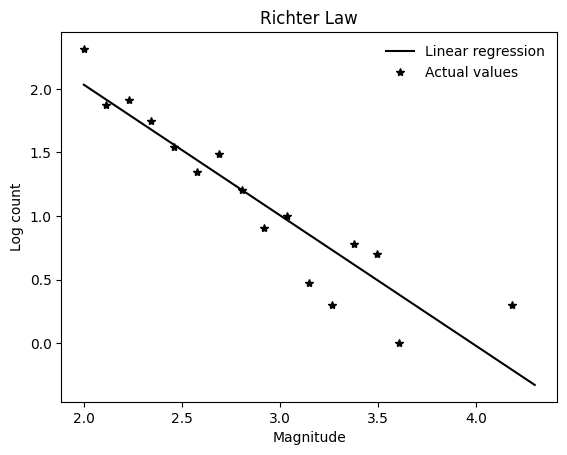

In [6]:
sicilia.richter(plot=True)

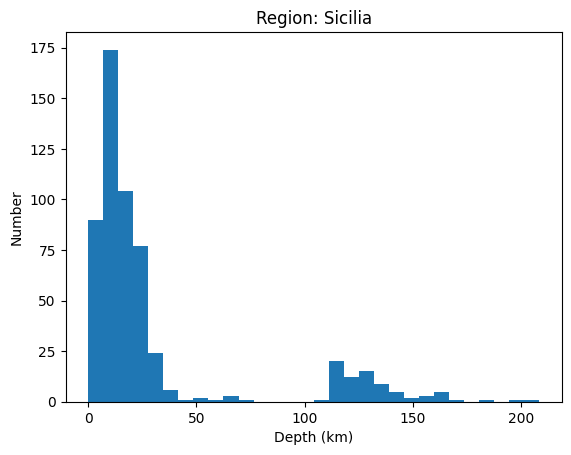

In [7]:
sicilia.depth_distribution()

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 475
Intercept: 3.90,   Slope: -0.9792


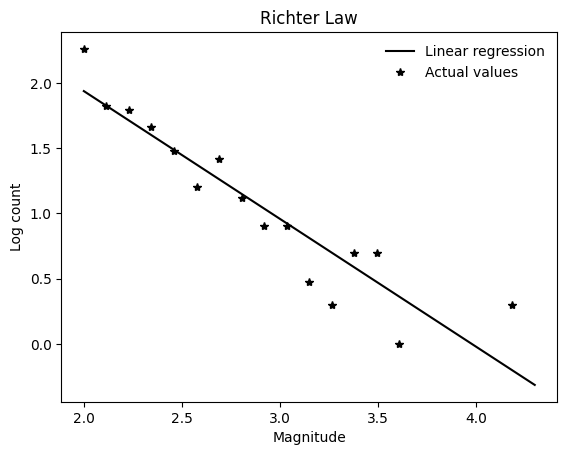

In [8]:
sicilia.richter(d_max=40, plot=True)

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 471
Intercept: 4.50,   Slope: -1.0580


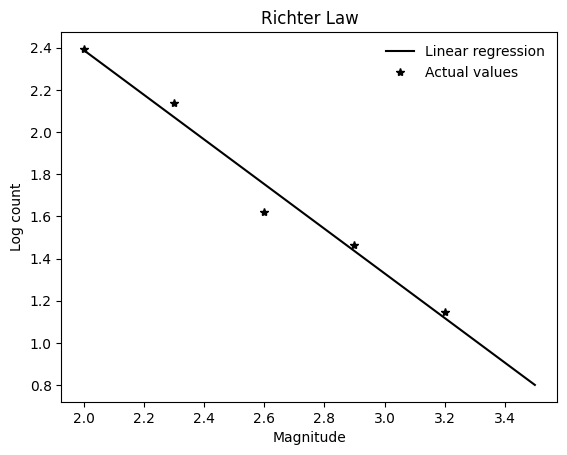

In [11]:
sicilia.bins=5
sicilia.richter(d_max=40, mgx=3.5, plot=True)

In [13]:
ec=central+emilia

In [14]:
ec.describe()

data-set: central_emilia
Size:  511
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.30
Stand. dev:          0.35

Depths (km):
Minimum depth:    1.1, maximum depth   71.1



In [15]:
ec.richter()

data-set: central_emilia
Size:  511
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.30
Stand. dev:          0.35

Depths (km):
Minimum depth:    1.1, maximum depth   71.1

Fit results:
Number of events: 511
Intercept: 4.01,   Slope: -1.0400


In [17]:
Data.describe_all()

Number of datasets: 5
Regions: ['sicilia', 'north', 'central', 'emilia', 'central_emilia']

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Richter fit:
Intercept: 5.02,   Slope: -1.2126

data-set: north
Size:  131
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.36
Stand. dev:          0.39

Depths (km):
Minimum depth:    1.5, maximum depth   62.4

Richter fit:
Intercept: 2.97,   Slope: -0.8141

data-set: central
Size:  367
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.29
Stand. dev:          0.34

Depths (km):
Minimum depth:    4.9, maximum depth   69.5

Richter fit:
Intercept: 4.01,   Slope: -1.0755

data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1


In [19]:
rd, ra=Data.set_array(out=True)

In [20]:
print(rd)

{'sicilia': 0, 'north': 1, 'central': 2, 'emilia': 3, 'central_emilia': 4}


In [21]:
def describe(region_name):
    rd, ra=Data.set_array(out=True)
    ra[rd[region_name]].describe()

def richter(region_name, bins=20, mgm=0, mgx=0, d_min=0, d_max=0, plot=False):
    rd, ra=Data.set_array(out=True)
    
    if bins != 20:
       ra[rd[region_name]].bins=bins
       
    ra[rd[region_name]].richter(mgm, mgx, d_min, d_max, plot=plot)  
    
def depth_distribution(region_name):
    rd, ra=Data.set_array(out=True)
    Data.depth_distribution(ra[rd[region_name]])

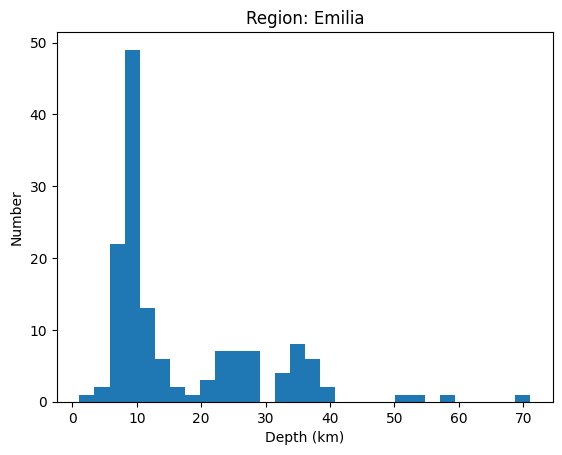

In [23]:
depth_distribution('emilia')

In [24]:
describe('emilia')

data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1



data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1

Fit results:
Number of events: 96
Intercept: 4.32,   Slope: -1.3197


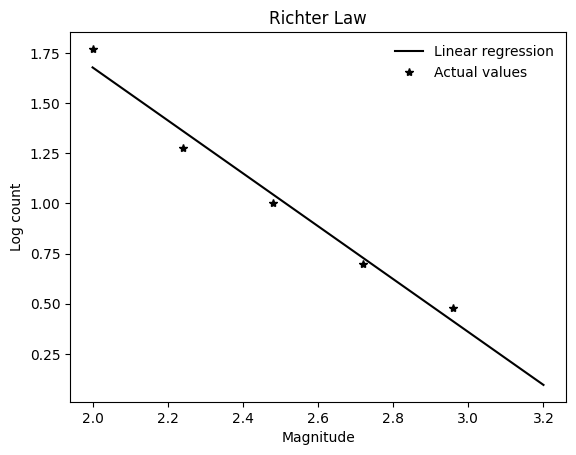

In [26]:
richter('emilia', bins=5, d_max=18, mgx=3.2, plot=True)

In [29]:
Data.region_names_for_dictionary

['sicilia', 'north', 'central', 'emilia', 'central_emilia']

In [30]:
for name in Data.region_names_for_dictionary:
    richter(name, bins=8)

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 559
Intercept: 4.68,   Slope: -1.1153
data-set: north
Size:  131
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.36
Stand. dev:          0.39

Depths (km):
Minimum depth:    1.5, maximum depth   62.4

Fit results:
Number of events: 131
Intercept: 3.47,   Slope: -0.9287
data-set: central
Size:  367
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.29
Stand. dev:          0.34

Depths (km):
Minimum depth:    4.9, maximum depth   69.5

Fit results:
Number of events: 367
Intercept: 4.54,   Slope: -1.1795
data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1

Fit results:
Number of event